# MOAAP: Multi-Object Analysis of Atmospheric Phenomena - Tutorial

This notebook demonstrates the usage of the MOAAP tracking algorithm. It is divided into two parts:
1.  **Standard Workflow**: Running MOAAP on real atmospheric data (ERA5 sample) to identify phenomena like MCSs.
2.  **Algorithm Deep-Dive**: Testing the core segmentation algorithm (Watershedding) on idealized synthetic data to understand how objects are defined in 2D vs 3D.

In [1]:
#!pip install git+https://github.com/andreas-prein/MOAAP.git # (only if the package is not already installed)

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /glade/u/home/prein/MyPython_Programs/python/packages/cdo-1.2.1/lib/python2.7/site-packages/cdo-1.2.1-py2.7.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Cloning https://github.com/andreas-prein/MOAAP.git to /glade/derecho/scratch/prein/tmp/pip-req-build-tjs92rnu
  Running command git clone --filter=blob:none --quiet https://github.com/andreas-prein/MOAAP.git /glade/derecho/scratch/prein/tmp/pip-req-build-tjs92rnu
  Resolved https://github.com/andreas-prein/MOAAP.git to commit a419659e97d59747576ef1535b90f4e8b09a85fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for moaap: filename=moaap-0.1.0-py3-none-any.whl size=68712 sha256=fe

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import os
import warnings
import pickle
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")

# --- MOAAP Imports ---
# Main Driver
from moaap import moaap

# Segmentation Tools
from moaap.utils.segmentation import (
    watershed_2d_overlap, 
    watershed_3d_overlap_parallel
)

## Part 1: Running MOAAP on Real Data

In this section, we load a sample dataset (24 hours of ERA5 data) and run the main `moaap` driver to identify atmospheric objects.

In [3]:
# 1. Load Data
# Ensure you have the sample file '20210701-04_MOAAP-Input_24h.nc' in your directory
# If not, you might need to download it (e.g., via gdown as in the original tutorial)

try:
    data_vars = xr.open_dataset('20210701-04_MOAAP-Input_24h.nc')
    print("Data loaded successfully.")
except FileNotFoundError:
    !gdown 1hD9hD3c9rBhcTN-c5FN87l0pHp_SCscE
    data_vars = xr.open_dataset('20210701-04_MOAAP-Input_24h.nc')
    print("Data downloaded and loaded successfully.")

# 2. Setup Parameters
dT = 1 # time interval [hours]
Mask = np.ones_like(data_vars['lon'].values) # Global tracking
DataName = 'ERA5'
OutputFolder = 'moaap_output/'

if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)

time_datetime = pd.to_datetime(data_vars['time'].values)

Downloading...
From (original): https://drive.google.com/uc?id=1hD9hD3c9rBhcTN-c5FN87l0pHp_SCscE
From (redirected): https://drive.google.com/uc?id=1hD9hD3c9rBhcTN-c5FN87l0pHp_SCscE&confirm=t&uuid=f2322f1d-d759-4205-863e-819aad781e13
To: /glade/u/home/prein/MajorCodeDevelopments/Feature_Tracker/MOAAP_v2.0/MOAAP/20210701-04_MOAAP-Input_24h.nc
100%|███████████████████████████████████████| 2.41G/2.41G [00:16<00:00, 146MB/s]
Data downloaded and loaded successfully.


### Run the Tracking

We call the `moaap` function. Note that we are only passing `pr` (Precipitation) and `tb` (Brightness Temperature) for this example to detect MCSs (Mesoscale Convective Systems). Other variables are set to `None` to speed up this tutorial.

In [4]:
# Clean up previous run
if os.path.exists(f"{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc"):
    os.remove(f"{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc")

# Run MOAAP
object_split = moaap(
    data_vars['lon'],
    data_vars['lat'],
    time_datetime,
    dT,
    Mask,
    pr=data_vars['PR'].values,
    tb=data_vars['Tb'].values,
    DataName=DataName,
    OutputFolder=OutputFolder,
    js_min_anomaly=12,
    MinTimeJS=12,
    # Set others to None for this tutorial
    v850=None, u850=None, t850=None, q850=None,
    slp=None, ivte=None, ivtn=None,
    z500=None, v200=None, u200=None
)

 
The provided variables allow tracking the following phenomena
 
|  phenomenon  | tracking |
---------------------------
   Jetstream   |   no
   PSL CY/ACY  |   no
   Z500 CY/ACY |   no
   COLs        |   no
   IVT ARs     |   no
   MS ARs      |   no
   Fronts      |   no
   TCs         |   no
   MCSs        |   yes
   clouds      |   yes
   Equ. Waves  |   yes
---------------------------
 
======> track tropical waves
        track tropical waves
            work on ER
Only one chunk specified, running serial version.
                connect waves objects over date line
            work on MRG
Only one chunk specified, running serial version.
                connect waves objects over date line
            work on IGW
Only one chunk specified, running serial version.
                connect waves objects over date line
            work on Kelvin
Only one chunk specified, running serial version.
                connect waves objects over date line
            work on Eig0
Only one c

1287it [00:00, 5604.51it/s]


            Loop over 1287 objects
            Loop over 77 objects
        00:00:02.40
======> 'track high clouds in Tb field by excluding MCS objects
        track  clouds
        break up long living cloud shield objects with wathershedding
    Minimum distance between TB minima for watershed analysis: 40 grid cells
Only one chunk specified, running serial version.
        make sure that each object has at least one grid cell with more than min_pr threshold of precipitation


340it [00:00, 7684.98it/s]

            Loop over 328 objects


        00:00:01.42
 
Save the object masks into a joint netCDF
Saved: moaap_output/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc
        00:00:05.37


### Visualize Results

Let's plot the identified MCS objects and their tracks on a map.

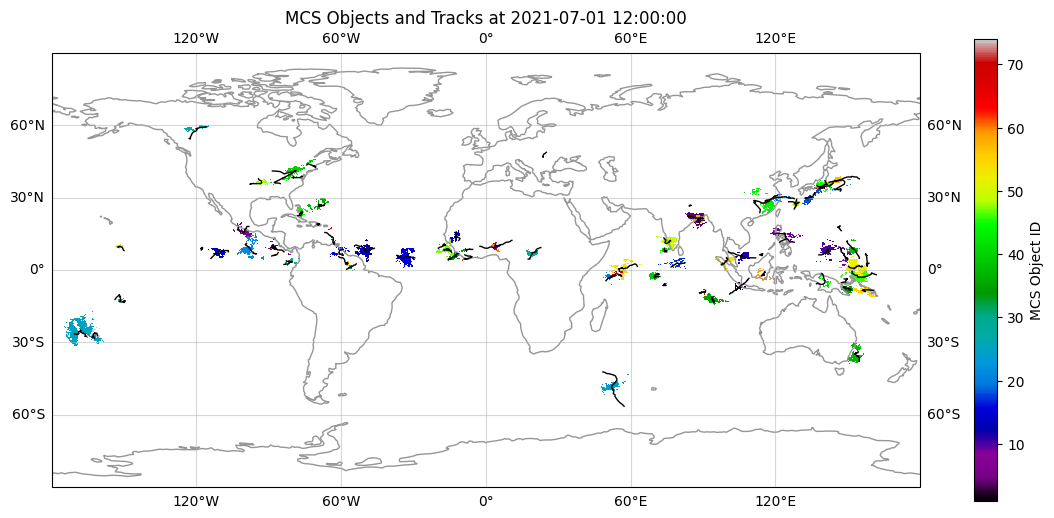

In [5]:
# Load the output
output_file = f'{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc'
if os.path.exists(output_file):
    data_moaap = xr.open_dataset(output_file)
    
    # Load MCS characteristics (tracks, size, etc.)
    pkl_file = f'{OutputFolder}/MCSs_202107__dt-1h_MOAAP-masks.pkl'
    if os.path.exists(pkl_file):
        with open(pkl_file, 'rb') as f:
            mcs_charac = pickle.load(f)

    # Plotting
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14, 6))
    ax.coastlines(color='#969696')
    ax.gridlines(draw_labels=True, alpha=0.5)

    # Select a specific time step (e.g., index 12)
    t_idx = 12
    if 'MCS_Tb_Objects' in data_moaap:
        mcs_mask = data_moaap['MCS_Tb_Objects'][t_idx, :, :].values.astype(float)
        mcs_mask[mcs_mask == 0] = np.nan
        
        sc = ax.pcolormesh(data_moaap['lon'], data_moaap['lat'], mcs_mask, 
                           cmap='nipy_spectral', transform=ccrs.PlateCarree())
        plt.colorbar(sc, ax=ax, label='MCS Object ID')

        # Plot tracks
        if 'mcs_charac' in locals():
            for obj_id in mcs_charac.keys():
                track = mcs_charac[obj_id]['track']
                ax.plot(track[:, 1], track[:, 0], 'k-', linewidth=1, transform=ccrs.PlateCarree())

    ax.set_title(f'MCS Objects and Tracks at {time_datetime[t_idx]}')
    plt.show()
else:
    print("MOAAP output not found. Did the tracking run successfully?")

### Part 1.2: Run with full dataset and analyze
In this section, we run MOAAP with the full set of atmospheric variables to identify a broader range of phenomena. We will then analyze the results, including object statistics and tracks. In the end, we will visualite some of the identified objects and generate a gif animation of their evolution over time.

There will be a history diagram of the MCS objects showing their life cycles with merges and splits.

Running MOAAP with full dataset (this may take a moment)...
 
The provided variables allow tracking the following phenomena
 
|  phenomenon  | tracking |
---------------------------
   Jetstream   |   yes
   PSL CY/ACY  |   yes
   Z500 CY/ACY |   yes
   COLs        |   yes
   IVT ARs     |   yes
   MS ARs      |   yes
   Fronts      |   yes
   TCs         |   yes
   MCSs        |   yes
   clouds      |   yes
   Equ. Waves  |   yes
---------------------------
 
======> track jetstream
    track jet streams
        break up long living jety objects with the watershed method
Only one chunk specified, running serial version.
            Loop over 29 objects
        00:00:02.85
======> track tropical waves
        track tropical waves
            work on ER
Only one chunk specified, running serial version.
                connect waves objects over date line
            work on MRG
Only one chunk specified, running serial version.
                connect waves objects over date line
       

1287it [00:00, 4566.62it/s]


    Minimum distance between TB minima for watershed analysis: 8 grid cells
Pre-calculating all label 2D centers at each time slice...
    Printing union array: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 31, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 31, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 45, 58: 4, 59: 59, 60: 8, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 20, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77}
    Printing events: [{'type': 'merge', 'time': 21, 'from_label': 19, 'to_label': 50, 'distance': 7.7347866632283155}, {'type': 'split', 'time': 5, 'from_label': 31, 'to_label': 50, 'distance': 7.962027789294027}, {'type': 'split', 'time': 8,

340it [00:00, 6257.96it/s]

            Loop over 328 objects


        00:00:01.41
======> Check if cyclones qualify as TCs


100%|██████████| 15/15 [00:00<00:00, 123.38it/s]


        00:00:00.79
 
Save the object masks into a joint netCDF
Saved: moaap_output/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc
        00:00:22.00
Tracking complete.


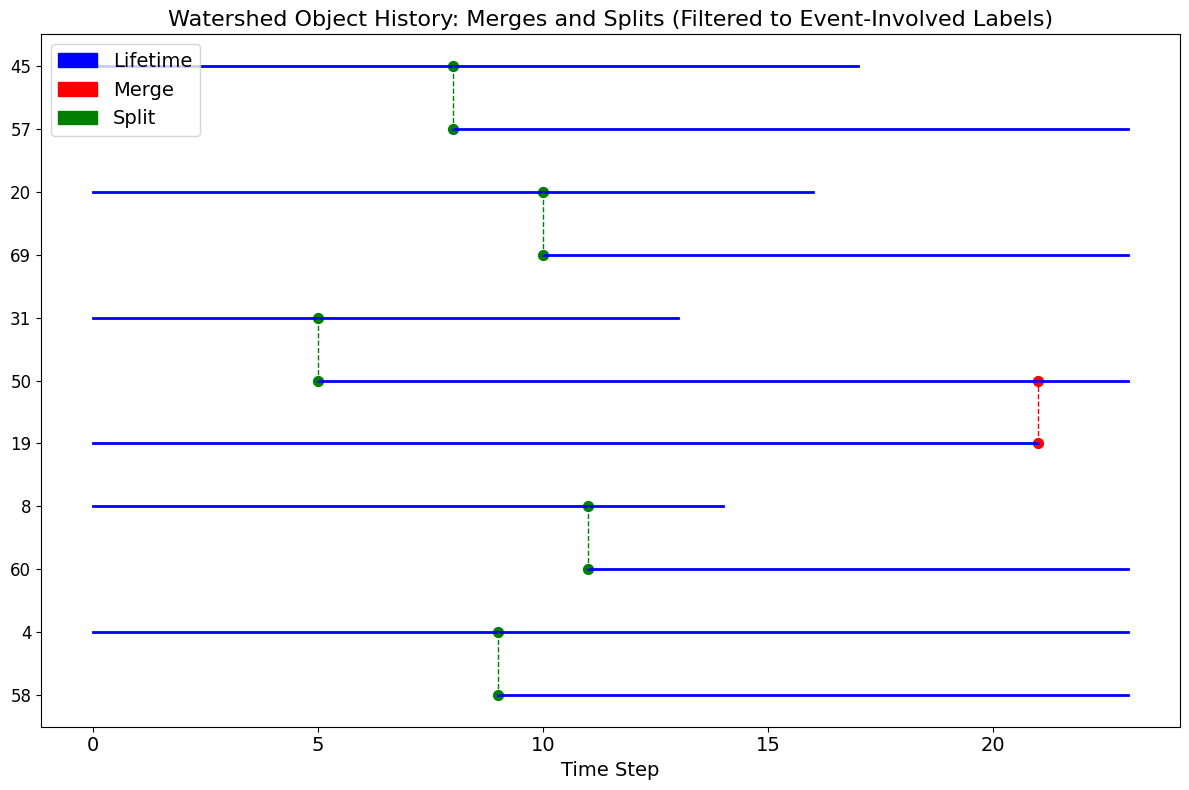

In [7]:
print("Running MOAAP with full dataset (this may take a moment)...")

# Clean up previous run to ensure fresh output
if os.path.exists(f"{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc"):
    os.remove(f"{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc")

object_split = moaap(
    data_vars['lon'],
    data_vars['lat'],
    time_datetime,
    dT,
    Mask,
    v850 = data_vars['V850'].values,
    u850 = data_vars['U850'].values,
    t850 = data_vars['T850'].values,
    q850 = data_vars['Q850'].values,
    slp = data_vars['SLP'].values,
    ivte = data_vars['IVTE'].values,
    ivtn = data_vars['IVTN'].values,
    z500 = data_vars['Z500'].values,
    v200 = data_vars['V200'].values,
    u200 = data_vars['U200'].values,
    pr   = data_vars['PR'].values,
    tb   = data_vars['Tb'].values,
    DataName = DataName,
    OutputFolder = OutputFolder,
    MinTimeJS = 12,
    analyze_mcs_history = True
)
print("Tracking complete.")

In [10]:
# Generate Frames and GIF
from tqdm import tqdm
from PIL import Image
import glob

# Reload the output to ensure we have the latest masks
output_file = f'{OutputFolder}/202107_ERA5_ObjectMasks__dt-1h_MOAAP-masks.nc'
data_moaap = xr.open_dataset(output_file)

# Legend configuration
object_names = [
    ['cold clouds', '#737373', '-', 2],
    ['surface cyclones', 'k', '-', 2],
    ['mid-level cyclones', 'k', '--', 2],
    ['anticyclones', '#ff7f00', '-', 2],
    ['MCS', '#33a02c', '-', 2],
    ['moisture streams', 'r', '-', 2],
    ['jets', '#6a3d9a', '-', 2],
    ['Rossby waves', '#8c510a', '-', 3],
    ['mixed Rossby gravity waves', '#bf812d', '-', 1.5],
    ['inertia gravity waves', '#dfc27d','-', 3],
    ['Kelvin waves', '#abd9e9','-', 1.5],
    ['eastward inertia gravity waves', '#4575b4', '-', 3],
    ['fronts', '#cab2d6', '-', 2]
]

# Plotting configuration (Variable Name -> Style)
# Note: We check for both generic names and specific variable names (e.g. CY_z500_Objects)
object_plotting_config = {
    'MCS_Tb_Objects': {'colors': '#33a02c', 'threshold': 0, 'linewidth': 1},
    'CY_z500_Objects': {'colors': 'k', 'threshold': 0, 'linewidth': 1}, 
    'COL_Objects': {'colors': 'k', 'threshold': 0, 'linewidth': 1, 'linestyles': '--'},
    'ACY_z500_Objects': {'colors': '#ff7f00', 'threshold': 0, 'linewidth': 1},
    'JET_Objects': {'colors': '#6a3d9a', 'threshold': 0, 'linewidth': 1},
    'AR_Objects': {'colors': 'r', 'threshold': 0, 'linewidth': 1},
    'FR_Objects': {'colors': '#cab2d6', 'threshold': 1, 'linewidth': 0.5},
    'ER_Objects': {'colors': '#8c510a', 'threshold': 1, 'linewidth': 0.5}
}

# Create images directory
images_dir = 'images'
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

print("Generating frames...")
for tt in tqdm(range(len(time_datetime))):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(14,6))
    ax.coastlines(color='#969696')
    ax.gridlines(draw_labels=False, alpha=0.5)
    
    # Plot available objects
    for obj_name, config in object_plotting_config.items():
        if obj_name in data_moaap.data_vars:
            plot_args = {
                'colors': config['colors'],
                'levels': range(0, 2, 1),
                'linewidths': config.get('linewidth', 1)
            }
            if 'linestyles' in config:
                plot_args['linestyles'] = config['linestyles']
            
            # Handle potential NaN or 0 masking
            field = np.array(data_moaap[obj_name][tt,:,:])
            if np.any(field > config['threshold']):
                ax.contour(data_moaap['lon'], data_moaap['lat'], 
                           field > config['threshold'], 
                           **plot_args, transform=ccrs.PlateCarree())

    ax.set_title(f'Objects identified by MOAAP at {str(time_datetime[tt])[:16]}')
    
    # Create legend
    legend_elements = []
    for ob in range(len(object_names)):
        line, = plt.plot([], [], color=object_names[ob][1], 
                 linestyle=object_names[ob][2],
                 lw=object_names[ob][3],
                 label=object_names[ob][0])
        legend_elements.append(line)

    # ax.legend(handles=legend_elements, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.legend(bbox_to_anchor=(1, 0.00), ncol=4)

    
    # Save frame
    plt.savefig(f'{images_dir}/{str(tt).zfill(3)}_frame.jpg', bbox_inches='tight', dpi=100)
    plt.close(fig)

# Create GIF
print("Creating GIF...")
frames = [Image.open(image) for image in sorted(glob.glob(f"{images_dir}/*_frame.jpg"))]
gif_path = "phenomenon.gif"
if frames:
    frames[0].save(gif_path, format="GIF", append_images=frames[1:],
                   save_all=True, duration=200, loop=0)
    print(f"GIF saved to {gif_path}")
else:
    print("No frames found to create GIF.")

Generating frames...


100%|██████████| 24/24 [00:13<00:00,  1.79it/s]


Creating GIF...
GIF saved to phenomenon.gif


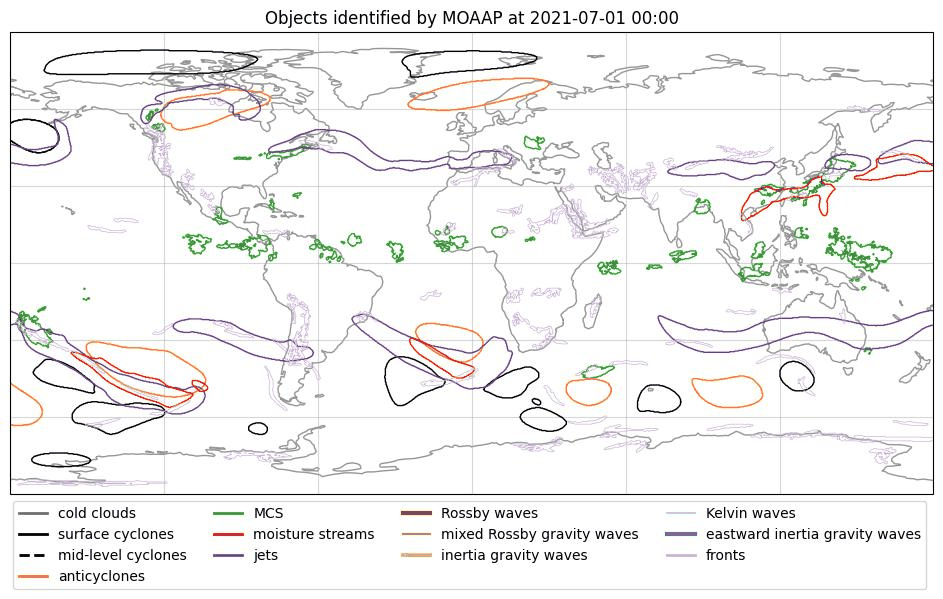

In [11]:
# Display the GIF
from IPython.display import Image as IPImage
if os.path.exists("phenomenon.gif"):
    display(IPImage(open("phenomenon.gif", 'rb').read()))
else:
    print("GIF not found.")

## Part 2: Watershedding Algorithm Test

MOAAP relies heavily on watershedding for segmentation. Here, we test this core component using idealized synthetic data (moving "blobs") to verify how the algorithm handles object separation and continuity in time.

We will compare:
1.  **2D Watershedding**: Applied frame-by-frame.
2.  **3D Watershedding**: Applied on the space-time cube (x, y, t).
3. **Parallel 3D Watershedding**: Applied on the space-time cube using parallel processing for large datasets.

In [12]:
def generate_synthetic_moving_cells(seed: int = 42):
    """
    Generates a 3D field (time, lat, lon) with synthetic moving circular 'storms'.
    Background is 300K, storms have lower temperatures (e.g., 210K).
    """
    np.random.seed(seed)
    # n_time, n_lat, n_lon = 48, 200, 200
    # n_cells = 30
    # speed = 3.0
    n_time, n_lat, n_lon = 24, 100, 100
    n_cells = 10
    speed = 2.0

    # Initialize background field
    data = np.full((n_time, n_lat, n_lon), 300.0)
    yy, xx = np.ogrid[:n_lat, :n_lon]

    boundary_val = 240.0
    center_val = 215.0

    for _ in range(n_cells):
        duration = np.random.randint(6, (n_time * 3) // 4 + 1)
        start = np.random.randint(0, n_time - duration + 1)
        
        max_area = np.random.uniform(200, 1500)
        max_radius = np.sqrt(max_area / np.pi)
        
        margin = int(np.ceil(max_radius))
        i0 = np.random.randint(margin, n_lat - margin)
        j0 = np.random.randint(margin, n_lon - margin)
        
        angle = np.random.uniform(0, 2 * np.pi)
        vy = speed * np.sin(angle)
        vx = speed * np.cos(angle)
        
        half = duration / 2
        for dt in range(duration):
            t = start + dt
            cy = i0 + vy * dt
            cx = j0 + vx * dt
            
            if dt < half:
                r = 1 + (max_radius - 1) * (dt / half)
            else:
                r = max_radius - (max_radius - 1) * ((dt - half) / half)
            
            dist = np.sqrt((yy - cy)**2 + (xx - cx)**2)
            mask = dist <= r
            
            vals = center_val + (boundary_val - center_val) * (dist / r)
            
            slice_t = data[t]
            slice_t[mask] = np.minimum(slice_t[mask], vals[mask])
            data[t] = slice_t

    return data

# Generate the data
synthetic_data = generate_synthetic_moving_cells(seed=43)
print(f"Generated synthetic data shape: {synthetic_data.shape}")

Generated synthetic data shape: (24, 100, 100)


### Run Watershedding

We apply the watershedding algorithm. Note that for atmospheric data (like brightness temperature), we often invert the data (multiply by -1) because watershedding looks for the maxima, but storms are defined by low temperatures.

Before running the code, make sure to have min_dist at least set to 4 for the 3D cases to ensure proper object separation without numerical artifacts. 

To run the parallel 3D code instead of the sequential version, set n_chunks_lat or n_chunks_lon to values greater than 1. The parallel code will also be called automatically if the memory overhead of the sequential code is larger than the available system memory.

The parallel code divides the data into spatial chunks with some overlap to ensure continuity of objects across chunk boundaries. In the end, the chunks are merged back together, leading to a little slower performance compared to the sequential version.



In [13]:
# Parameters
tb_threshold = 241 # K
dT = 1

# 1. Run 2D Watershedding (Frame by Frame)
print("Running 2D Watershedding...")
C_objects_2d = watershed_2d_overlap(
    synthetic_data * -1,
    tb_threshold * -1,
    -235, 
    5, # min distance
    dT,
    mintime=0,
    connectLon=0,
    extend_size_ratio=0.10
)

# 2. Run 3D Watershedding (Space-Time)
print("Running 3D Watershedding...")
C_objects_3d = watershed_3d_overlap_parallel(
    synthetic_data * -1,
    tb_threshold * -1,
    -235,
    5, # min distance
    dT,
    mintime=0,
    connectLon=0,
    extend_size_ratio=0.10,
    n_chunks_lat=1,
    n_chunks_lon=1
)

# 3. Run parallel 3D Watershedding (Space-Time)
print("Running parallel 3D Watershedding...")
C_objects_3d_pll = watershed_3d_overlap_parallel(
    synthetic_data * -1,
    tb_threshold * -1,
    -235,
    5, # min distance
    dT,
    mintime=0,
    connectLon=0,
    extend_size_ratio=0.10,
    n_chunks_lat=2,
    n_chunks_lon=2
)

print(f"Max 2D Objects: {np.max(C_objects_2d)}")
print(f"Max 3D Objects: {np.max(C_objects_3d)}")
print(f"Max Parallel 3D Objects: {np.max(C_objects_3d_pll)}")

Running 2D Watershedding...


100%|██████████| 23/23 [00:00<00:00, 441.38it/s]

Running 3D Watershedding...
Only one chunk specified, running serial version.
Running parallel 3D Watershedding...
    Processing 4 chunks with 0.00 GB halo buffer...


    Merging chunk results...
    Applying labels in-place...
Max 2D Objects: 17
Max 3D Objects: 11
Max Parallel 3D Objects: 11


### Visualization and Comparison

We create a side-by-side animation to compare the raw input, the 2D result, and the 3D result.

In [14]:
def make_comparison_animation(raw_data, objects_2d, objects_3d, objects_3d_pll):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    
    # Setup colormaps
    # 'gist_ncar' provides high contrast for object labels
    cmap_obj = plt.get_cmap('gist_ncar')
    cmap_obj.set_under('lightblue') # Set background (value 0) to light blue
    
    # Determine global max for consistent color scaling across 2D and 3D
    max_2d = np.max(objects_2d)
    max_3d = np.max(objects_3d)
    max_3d_pll = np.max(objects_3d_pll)

    # Initial frames
    # 1. Raw Data
    im1 = ax1.imshow(raw_data[0], cmap='viridis_r', vmin=210, vmax=300, origin='lower')
    ax1.set_title('Raw Data (Tb)')
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Temperature [K]')
    
    # 2. 2D Objects
    # We pass the raw array (with 0s). vmin=1 ensures 0 is treated as "under" (background)
    im2 = ax2.imshow(objects_2d[0], cmap=cmap_obj, vmin=1, vmax=max_2d, origin='lower')
    ax2.set_title('2D Watershed')
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Object ID')
    
    # 3. 3D Objects
    im3 = ax3.imshow(objects_3d[0], cmap=cmap_obj, vmin=1, vmax=max_3d, origin='lower')
    ax3.set_title('3D Watershed')
    fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Object ID')

    # 4. parallel 3D Objects
    im4 = ax4.imshow(objects_3d_pll[0], cmap=cmap_obj, vmin=1, vmax=max_3d_pll, origin='lower')
    ax4.set_title('Parallel 3D Watershed')
    fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04, label='Object ID')
    
    title = fig.suptitle('Time step: 0')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    def update(frame):
        im1.set_data(raw_data[frame])
        im2.set_data(objects_2d[frame])
        im3.set_data(objects_3d[frame])
        im4.set_data(objects_3d_pll[frame])
        
        title.set_text(f'Time step: {frame}')
        return [im1, im2, im3, title]

    anim = animation.FuncAnimation(fig, update, frames=len(raw_data), interval=200, blit=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

# Generate and display the animation
animation_html = make_comparison_animation(synthetic_data, C_objects_2d, C_objects_3d, C_objects_3d_pll)
display(animation_html)